In [233]:
from sklearn.cluster import KMeans
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial.distance import pdist, squareform
from sklearn.datasets import make_blobs
import networkx as nx
import matplotlib.pyplot as plt

points_count = 50
to_plot = False
no_centres = 1

In [234]:
X, Y = make_blobs(n_samples=points_count, centers=no_centres, random_state=42)
points = [(x, y) for x, y in X]
points = list(set([(round(x, 2) , round(y , 2)) for x , y in points]))

In [235]:
n = len(points)
k = int(n**0.5)

kmeans = KMeans(n_clusters=k).fit(points)
labels = kmeans.labels_
centers = kmeans.cluster_centers_.tolist()
sub_graphs = [[] for _ in range(k)]
for point, label in zip(points, labels):
    sub_graphs[label].append(point)
print(k, len(sub_graphs))

7 7


/home/voy/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [236]:
import math
import time

eprim_start_time = time.time()


def calculate_distance(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)


def prim_mst(points):
    n = len(points)
    visited = [False] * n
    min_cost = [float("inf")] * n
    parent = [None] * n

    min_cost[0] = 0
    parent[0] = -1

    for _ in range(n):
        min_index = -1
        for i in range(n):
            if not visited[i] and (
                min_index == -1 or min_cost[i] < min_cost[min_index]
            ):
                min_index = i

        visited[min_index] = True

        for i in range(n):
            if not visited[i]:
                distance = calculate_distance(points[min_index], points[i])
                if distance < min_cost[i]:
                    min_cost[i] = distance
                    parent[i] = min_index

    mst_edges = []
    for i in range(1, n):
        mst_edges.append((parent[i], i))

    return mst_edges


mst = prim_mst(points)
eprim_end_time = time.time()
eprim_elapsed_time = eprim_end_time - eprim_start_time
print(
    "MST Weight: ",
    eprim_wt := sum([calculate_distance(points[u], points[v]) for u, v in mst]),
)
print("time taken by dcran : ", eprim_elapsed_time)

MST Weight:  17.172989154792763
time taken by dcran :  0.0008618831634521484


In [237]:
msts1 = []
for graph in sub_graphs:
    msts1.append(prim_mst(graph))
    print(len(msts1[-1]) , len(graph))

11 12
6 7
7 8
7 8
0 1
4 5
8 9


In [238]:
print(centers)
mst_centres = prim_mst(centers)
print(mst_centres)

[[-2.7975, 8.666666666666666], [-1.4357142857142857, 9.26142857142857], [-2.3175, 10.3625], [-2.33875, 7.415], [-5.13, 9.84], [-3.8360000000000003, 8.15], [-3.2199999999999998, 9.46888888888889]]
[(2, 1), (6, 2), (0, 3), (6, 4), (0, 5), (0, 6)]


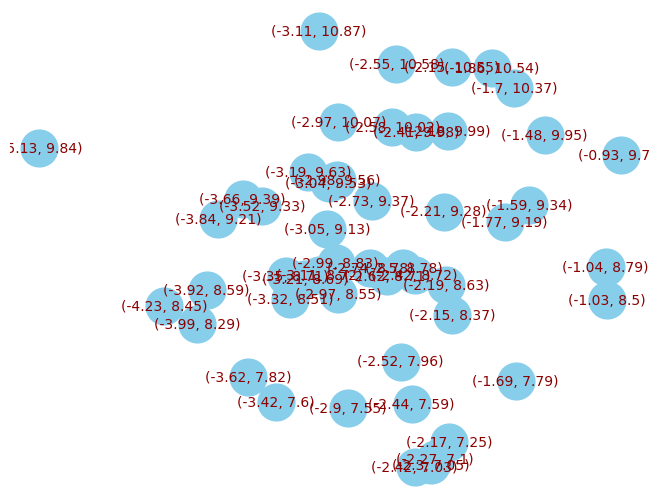

In [239]:
F = nx.Graph()
for point in points:
    F.add_node(point , pos = point)
pos = {point : point for point in points}
nx.draw(
    F,
    pos = pos,
    with_labels=True,
    node_color="skyblue",
    node_size=700,
    font_size=10,
    font_color="darkred",
)
plt.show()

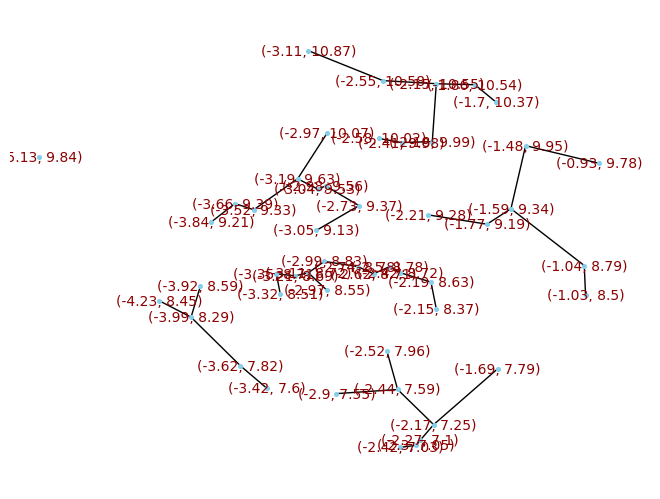

In [240]:
for sub_points , mst_edges in zip(sub_graphs , msts1):
    for u , v in mst_edges:
        F.add_edge(sub_points[u] , sub_points[v])
nx.draw(
    F,
    pos=pos,
    with_labels=True,
    node_color="skyblue",
    node_size=7,
    font_size=10,
    font_color="darkred",
)
plt.show()

In [241]:
import math
def connect(sg1 , sg2):
    centroid = (sum([x for x , y in sg1])/len(sg1) , sum([y for x , y in sg1])/len(sg1))
    def closest_point(sg2, centroid):
        min_distance = float('inf')
        closest_point = None
        
        for point in sg2:
            distance = math.sqrt((point[0] - centroid[0]) ** 2 + (point[1] - centroid[1]) ** 2)
            if distance < min_distance:
                min_distance = distance
                closest_point = point
        
        return closest_point

    closest_point_sg2 = closest_point(sg2, centroid)
    closest_point_sg1 = closest_point(sg1, closest_point_sg2)
    print(closest_point_sg1 , closest_point_sg2)    
    F.add_edge(closest_point_sg1 , closest_point_sg2)
    

In [242]:
new_centres = []
for s , e in mst_centres:
    connect(sub_graphs[s] , sub_graphs[e])
    mid_point = ((centers[s][0] + centers[e][0])/2 , (centers[s][1] + centers[e][1])/2)
    new_centres.append(mid_point)
print(new_centres)

(-1.7, 10.37) (-1.48, 9.95)
(-2.97, 10.07) (-2.58, 10.02)
(-2.15, 8.37) (-2.52, 7.96)
(-3.84, 9.21) (-5.13, 9.84)
(-3.35, 8.71) (-3.92, 8.59)
(-2.99, 8.83) (-3.05, 9.13)
[(-1.876607142857143, 9.811964285714286), (-2.76875, 9.915694444444444), (-2.568125, 8.040833333333333), (-4.175, 9.654444444444444), (-3.31675, 8.408333333333333), (-3.00875, 9.067777777777778)]


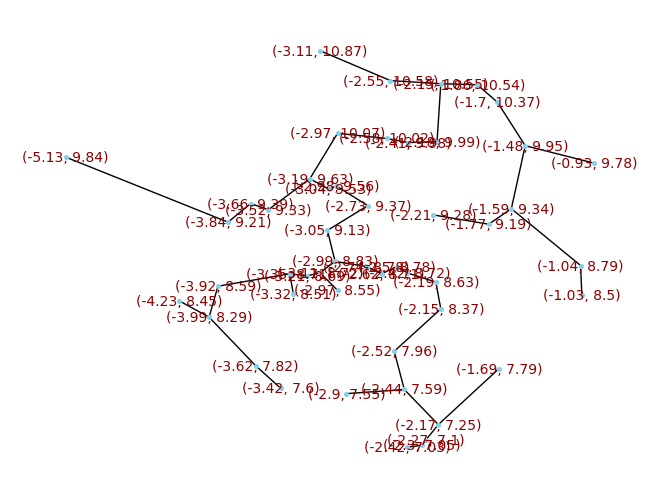

In [243]:
nx.draw(
    F,
    pos=pos,
    with_labels=True,
    node_color="skyblue",
    node_size=7,
    font_size=10,
    font_color="darkred",
)
plt.show()

In [244]:
kmeans2 = KMeans(n_clusters=len(new_centres), init=new_centres, n_init=1)
kmeans2.fit(new_centres)
labels2 = kmeans2.predict(points)

sub_graphs2 = [[] for _ in range(len(new_centres))]
for point, label in zip(points, labels2):
    sub_graphs2[label].append(point)    
print(len(sub_graphs2))



6


In [245]:
mst2 = []
for graph in sub_graphs2:
    mst2.append(prim_mst(graph))
    print(len(mst2[-1]) , len(graph))

10 11
6 7
9 10
2 3
8 9
9 10


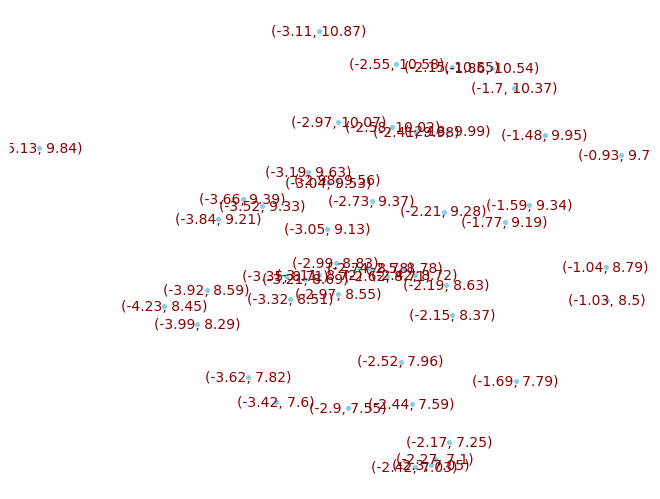

In [246]:
G = nx.Graph()
for point in points:
    G.add_node(point , pos = point)
pos = {point : point for point in points}
nx.draw(
    G,
    pos = pos,
    with_labels=True,
    node_color="skyblue",
    node_size=7,
    font_size=10,
    font_color="darkred",
)
plt.show()

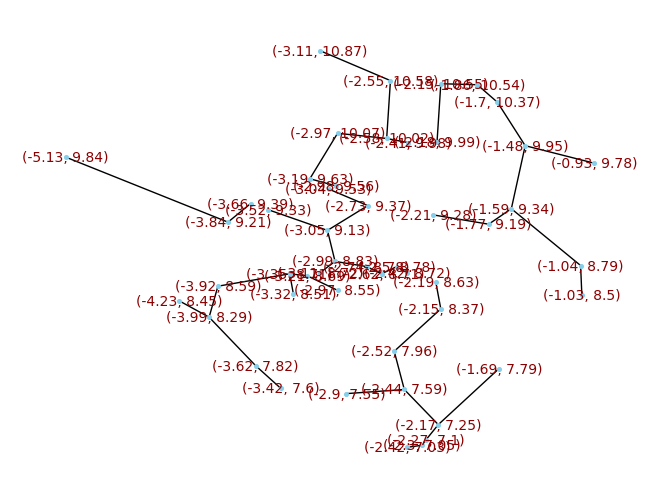

In [247]:
for sub_points , mst_edges in zip(sub_graphs2 , mst2):
    for u , v in mst_edges:
        G.add_edge(sub_points[u] , sub_points[v])
nx.draw(
    G,
    pos=pos,
    with_labels=True,
    node_color="skyblue",
    node_size=7,
    font_size=10,
    font_color="darkred",
)
plt.show()

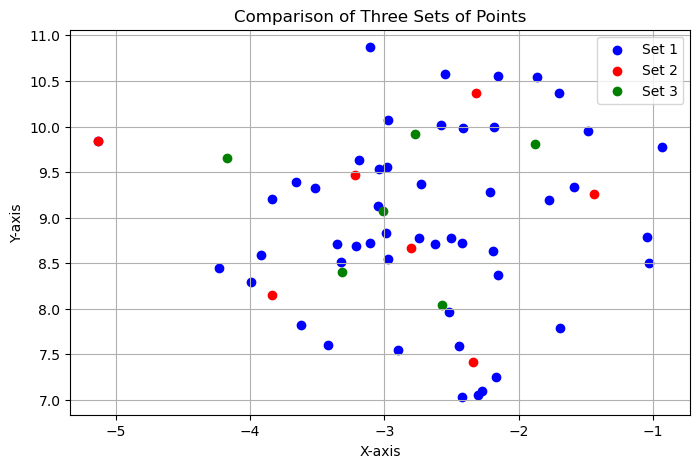

In [248]:
import matplotlib.pyplot as plt

# Example data: three sets of points
points1 = [(1, 2), (2, 3), (3, 5), (4, 7), (5, 11)]
points2 = [(1, 1), (2, 4), (3, 9), (4, 16), (5, 25)]
points3 = [(1, 1.5), (2, 2.5), (3, 3.5), (4, 4.5), (5, 5.5)]

# Unpacking points into x and y coordinates
x1, y1 = zip(*points)
x2, y2 = zip(*centers)
x3, y3 = zip(*new_centres)

# Creating the plot
plt.figure(figsize=(8, 5))
plt.scatter(x1, y1, color="blue", label="Set 1")  # Set 1 in blue
plt.scatter(x2, y2, color="red", label="Set 2")  # Set 2 in red
plt.scatter(x3, y3, color="green", label="Set 3")  # Set 3 in green

# Adding titles and labels
plt.title("Comparison of Three Sets of Points")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()

# Showing the plot
plt.grid(True)
plt.show()

In [249]:
a = [13 , 4 ,6]
b = [lambda x : x**2 for x in a]